# Create MNIST Petastorm Dataset

In this notebook we will go through how you can create a Petastorm dataset with the MNIST images of digits, and also how you can save it as a documented and reusable training dataset in the Hopsworks Feature Store. The petastorm dataset can later on be used to train models using either Tensorflow, PyTorch or SparkML

In [1]:
from hops import hdfs, featurestore
import numpy as np
import pydoop
import gzip
from tempfile import TemporaryFile

# IMPORTANT: must import  tensorflow before petastorm.tf_utils due to a bug in petastorm
import tensorflow as tf
from petastorm.unischema import dict_to_spark_row, Unischema, UnischemaField
from pyspark.sql.types import StructType, StructField, IntegerType
from petastorm.codecs import ScalarCodec, CompressedImageCodec, NdarrayCodec

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1551196216588_0003,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


### Step 1: Create a Hopsworks Dataset called "mnist" and Upload the MNIST images to Hopsworks

The MNIST dataset can be downloaded here: http://yann.lecun.com/exdb/mnist/, it consists of four files: 

- train-images-idx3-ubyte.gz:  training set images (9912422 bytes) 
- train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
- t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
- t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

The data is stored in the idx format. The IDX file format is a simple format for vectors and multidimensional matrices of various numerical types.

The basic format according to http://yann.lecun.com/exdb/mnist/ is:
```
magic number
size in dimension 1
size in dimension 2
size in dimension 3
....
size in dimension N
data
```
The magic number is four bytes long. The first 2 bytes are always 0.

The third byte codes the type of the data:
```
0x08: unsigned byte
0x09: signed byte
0x0B: short (2 bytes)
0x0C: int (4 bytes)
0x0D: float (4 bytes)
0x0E: double (8 bytes)
```
The fouth byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....

The sizes in each dimension are 4-byte integers (big endian, like in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes the fastest.

You could also have uploaded the .png images directly and read them using Spark: https://databricks.com/blog/2018/12/10/introducing-built-in-image-data-source-in-apache-spark-2-4.html 

But to save us the effort of uploading 70000 images and unzipping them, we will use Yann LeCunns IDX files. 

To upload the files, (1) download them from here: http://yann.lecun.com/exdb/mnist/; (2) Go to the dataset browser in Hopsworks in your project and click the button 'Create new dataset' and name the new dataset "mnist"; (3) Click on the dataset and upload the files.  

![Petastorm 3](./../images/petastorm3.png "Petastorm 3")

![Petastorm 4](./../images/petastorm4.png "Petastorm 4")


In [2]:
files = hdfs.ls(hdfs.project_path() + "mnist")
for i in range(len(files)):
    print(files[i])

hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/README.md
hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/t10k-images-idx3-ubyte.gz
hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/t10k-labels-idx1-ubyte.gz
hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/train-images-idx3-ubyte.gz
hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/train-labels-idx1-ubyte.gz

### Step 2: Parse the IDX files into Numpy Arrays

In [3]:
def read_mnist(train_num_examples, test_num_examples):
    """
    Parses MNIST dataset in the IDX format into numpy multi-dimensional arrays
    
    Args:
        :train_num_examples: number of training examples to parse
        :test_num_examples: number of test examples to parse
    
    Returns: train_images, train_labels, test_images, test_labels
    """
    image_size = 28
    train_num_examples = train_num_examples
    test_num_examples = test_num_examples
    train_images_path = hdfs.project_path() + "mnist/train-images-idx3-ubyte.gz"
    train_labels_path = hdfs.project_path() + "mnist/train-labels-idx1-ubyte.gz"
    test_images_path = hdfs.project_path() + "mnist/t10k-images-idx3-ubyte.gz"
    test_labels_path = hdfs.project_path() + "mnist/t10k-labels-idx1-ubyte.gz"
    image_padding = 16
    label_padding = 8
    def parse_zip(path, padding, bytes):
        f_zip = pydoop.hdfs.open(path, "rb")
        f_unzip = gzip.GzipFile(mode='rb', fileobj=f_zip)
        f_unzip.read(padding) # read metadata string
        return f_unzip.read(bytes)
    train_images_data = np.frombuffer(parse_zip(train_images_path, image_padding, image_size * image_size * train_num_examples), dtype=np.uint8)
    train_images = train_images_data.reshape(train_num_examples, image_size, image_size, 1)
    train_labels_data = np.frombuffer(parse_zip(train_labels_path, label_padding, train_num_examples), dtype=np.uint8).astype(np.int64)
    train_labels = train_labels_data.reshape(train_num_examples, 1)
    test_images_data = np.frombuffer(parse_zip(test_images_path, image_padding, image_size * image_size * test_num_examples), dtype=np.uint8)
    test_images = test_images_data.reshape(test_num_examples, image_size, image_size, 1)
    test_labels_data = np.frombuffer(parse_zip(test_labels_path, label_padding, test_num_examples), dtype=np.uint8).astype(np.int64)
    test_labels = test_labels_data.reshape(test_num_examples, 1)
    return train_images, train_labels, test_images, test_labels

In [4]:
train_images, train_labels, test_images, test_labels = read_mnist(60000, 10000)

### Step 3: Quick Data Validation

To validate that we parsed the data correctly we can try to visualize a bunch of images and compare the imaegs to their labels. Plotting in a distributed computing setting is a little bit tricky, it is explained in more details here: https://hopsworks.readthedocs.io/en/0.9/user_guide/hopsworks/jupyter.html#plotting-with-pyspark-kernel.

TLDR; We can save a few images to HDFS and read them in the %%local environment to plot them

##### Save a handful of images/labels to HDFS

In [4]:
from hops import numpy_helper as hops_numpy
hops_numpy.save("mnist/train_img_val.npy", train_images[0:2])
hops_numpy.save("mnist/train_lbl_val.npy", train_labels[0:2])
hops_numpy.save("mnist/test_img_val.npy", test_images[0:2])
hops_numpy.save("mnist/test_lbl_val.npy", test_labels[0:2])

##### Read sample images from HDFS in %%local and plot

###### Utility functions for plotting

In [2]:
%%local
import matplotlib.pyplot as plt
from hops import hdfs
import numpy as np
from tempfile import TemporaryFile
from hops import numpy_helper as hops_numpy

def plot_train_example(example_num):
    """
    Utility function that plots a training image together with its label 
    
    Args:
         :example_num: the id of the example to plot
    
    Returns: None
    """
    image = np.asarray(train_images_val[example_num]).squeeze()
    plt.imshow(image)
    print("label:" + str(train_lbls_val[example_num][0]))
    
def plot_test_example(example_num):
    """
    Utility function that plots a test image together with its label

    Args:
         :example_num: the id of the example to plot
    
    Returns: None
    """
    image = np.asarray(test_images_val[example_num]).squeeze()
    plt.imshow(image)
    print("label:" + str(test_lbls_val[example_num][0]))

###### Read images in %%local

In [7]:
%%local
train_images_val = hops_numpy.load("mnist/train_img_val.npy")
train_lbls_val = hops_numpy.load("mnist/train_lbl_val.npy")
test_images_val = hops_numpy.load("mnist/test_img_val.npy")
test_lbls_val = hops_numpy.load("mnist/test_lbl_val.npy")

###### Plot using matplotlib

label:5


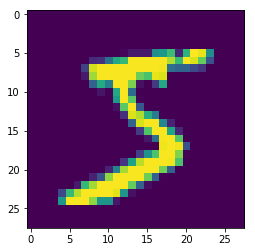

In [8]:
%%local
%matplotlib inline
plot_train_example(0)

label:0


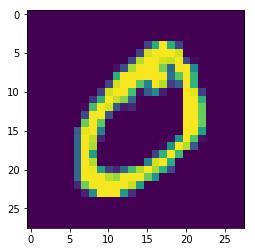

In [9]:
%%local
%matplotlib inline
plot_train_example(1)

label:7


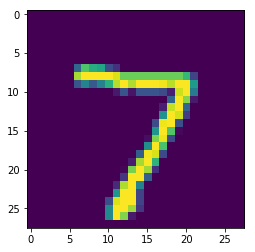

In [10]:
%%local
%matplotlib inline
plot_test_example(0)

label:2


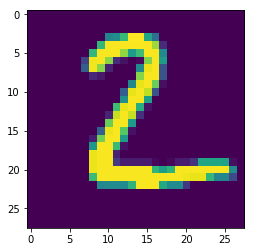

In [11]:
%%local
%matplotlib inline
plot_test_example(1)

### Step 4: Save  the Numpy Dataset as a Petastorm Dataset

We have now parsed the MNIST database of handwritten images into numpy arrays `train_images, train_labels, test_images, test_labels`. We can store this to HDFS as a Petastorm dataset by (1) specifying the petastorm schema; (2) convert the numpy data to a spark dataframe; (3) Save the data to petastorm training dataset in the featurestore using  `featurestore.create_training_dataset()` and set `data_format='petastorm'`.

#### Specify Petastorm Schema

Petastorm datasets are designed to be easy to read into deep learning frameworks such as Tensorflow and Pytorch. To enable this we need to specify the schema when writing the data to HDFS.

In [12]:
MnistSchema = Unischema('MnistSchema', [
    UnischemaField('image', np.uint8, (28, 28,1), NdarrayCodec(), False),
    UnischemaField('digit', np.int_, (), ScalarCodec(IntegerType()), False)
])

#### Create a Spark Dataframe with the data in the numpy arrays

Petastorm relies on Spark to write to HDFS so we have to convert the numpy arrays into a spark dataframe that conforms to the Petastorm schema.

In [13]:
TRAIN_OUTPUT_PATH = hdfs.project_path() + "mnist/train_petastorm"
TEST_OUTPUT_PATH = hdfs.project_path() + "mnist/test_petastorm" 
mnist_data = {
            'train': {"images": train_images, "labels": train_labels, "output_path": TRAIN_OUTPUT_PATH},
            'test': {"images": test_images, "labels": test_labels, "output_path": TEST_OUTPUT_PATH}
        }

First create an RDD of dict-rows with the numpy arrays and then convert the dict-rows into Spark Dataframe Rows using the petastorm utility function `dict_to_spark_row`. 

In [14]:
def create_petastorm_dict(i, test=False):
    """
    Returns a train or test example from mnist_data variable as a dict with the Petastorm schema
    
    Args:
        :i: the index of the example
        :test: a boolean flag whether to get a test example, otherwise gets a training example
    """
    if test:
        return {
            MnistSchema.digit.name: mnist_data["test"]["labels"][i],
            MnistSchema.image.name: mnist_data["test"]["images"][i]
        }
    return {
            MnistSchema.digit.name: mnist_data["train"]["labels"][i],
            MnistSchema.image.name: mnist_data["train"]["images"][i]
        } 

In [15]:
dataset_train_rdd = sc.parallelize(list(range(len(mnist_data["train"]["images"]))))\
        .map(lambda i: create_petastorm_dict(i))\
        .map(lambda x: dict_to_spark_row(MnistSchema, x))

In [16]:
dataset_test_rdd = sc.parallelize(list(range(len(mnist_data["test"]["images"]))))\
        .map(lambda i: create_petastorm_dict(i, test=True))\
        .map(lambda x: dict_to_spark_row(MnistSchema, x))

Then convert the RDDs to Spark Dataframes using `MnistSchema.as_spark_schema()`

In [17]:
df_train = spark.createDataFrame(dataset_train_rdd, MnistSchema.as_spark_schema())

In [18]:
df_test = spark.createDataFrame(dataset_test_rdd, MnistSchema.as_spark_schema())

**Note** Using dicts/rdds and then spark.createDataFrame() is just one approach to create a spark dataframe that conforms to the Petastorm schema. If you don't have the data in numpy arrays but rather saved on disk you might use another approach, the important thing is that you define a petastorm schema and that your dataframe's spark schema is equal to `petastorm_schema.as_spark_schema()`.

#### Save the Spark Dataframes as Training Dataset in the Petastorm Format in the Hopsworks Feature Store

All parameters available for the petastorm method `materialize_dataset` listed here: https://petastorm.readthedocs.io/en/latest/api.html can be provided as arguments in a dict to `featurestore.create_training_dataset(petastorm_args=dict)`. The only required argument is "schema".

In [23]:
petastorm_args = {
    "schema": MnistSchema
}

Save Dataset with Training Data:

In [20]:
featurestore.create_training_dataset(df_train, "MNIST_train_petastorm", data_format="petastorm", 
                                     petastorm_args=petastorm_args,
                                     description="MNIST Digit Database Training Dataset of 60000 images stored in the Petastorm Format",
                                     #this type of statistics do not make sense on image data
                                     feature_correlation=False, feature_histograms=False, cluster_analysis=False)

computing descriptive statistics for : MNIST_train_petastorm

In [24]:
petastorm_args = {
    "schema": MnistSchema
}

Save Dataset with Test Data:

In [25]:
featurestore.create_training_dataset(df_test, "MNIST_test_petastorm", data_format="petastorm", 
                                     petastorm_args=petastorm_args,
                                     description="MNIST Digit Database Test Dataset of 10000 images stored in the Petastorm Format",
                                     #this type of statistics do not make sense on image data
                                     feature_correlation=False, feature_histograms=False, cluster_analysis=False)

computing descriptive statistics for : MNIST_test_petastorm

### Step 5: Use the Training Dataset

Once the datasets are saved in the feature store you can find them in the Feature Registry inside your project and easily reuse it later. By saving the dataset as a petastorm dataset you can use the same data in several different deep learning frameworks, such as PyTorch and Tensorflow. We have two example notebooks that demonstrate this here:

- [Tensorflow Example](PetastormMNIST_Tensorflow.ipynb)

- [PyTorch Example](PetastormMNIST_PyTorch.ipynb)

![Petastorm 5](./../images/petastorm5.png "Petastorm 5")